In [30]:
import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [19]:
# try imputing missing values instead of dropping nan
# other evaluation metrics

In [28]:
# Drop rows with missing values, split labels from features
def preprocess_data(df, split_labels=True):
    df = df.dropna()
    df['feat_20'] = df['feat_20'].map({'YES': 1, 'NO': 0})
    if split_labels is False:
        return df
    # labels
    y = df.feat_20
    # features
    X = df.drop(columns=["feat_20"])
    return X, y

# convert features
def transform_data(data):
    enc = OneHotEncoder(handle_unknown='ignore')
    return enc.fit_transform(data)
   
# split data
def encode_and_split_data(data, labels, get="all_data"):
    feats = transform_data(data)
    if get == "all_data":
        return feats
    if get == "split_data":
        return train_test_split(feats, labels, test_size = 0.2, random_state=0, stratify=labels)
    
# Logistic Regression classifier
def train_eval_logreg(features, labels):
    logreg = LogisticRegression(solver="lbfgs")
    logreg.fit(features[0], labels[0])
    return test_result(logreg, features[1], labels[1])

# predict test set and report accuracy
def test_result(model, eval_data, eval_labels):
    preds = model.predict(eval_data)          
    return accuracy_score(preds, eval_labels)
    


In [21]:
df = pd.read_csv("anonymized_data.csv")

# start by looking at data
data = preprocess_data(df, split_labels=False)

In [22]:
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20
0,1.0,1.0,1.0,1.0,0,0.0,1.0,1.0,0.0,0.0,26.0,A,J,no,no,41.0,no,A,B,0
1,1.0,1.0,0.0,1.0,0,0.0,0.0,1.0,0.0,1.0,24.0,B,D,no,yes,12.0,no,A,B,0
2,1.0,1.0,0.0,1.0,1,0.0,1.0,1.0,1.0,1.0,27.0,B,D,yes,yes,24.0,no,A,A,1
3,1.0,1.0,0.0,1.0,0,0.0,1.0,1.0,0.0,1.0,35.0,A,J,no,yes,41.0,no,A,B,0
5,1.0,1.0,1.0,1.0,1,0.0,1.0,1.0,1.0,1.0,36.0,B,I,yes,no,41.0,no,A,B,1


In [23]:
# identify strong correlations (Pearson's rho by default)
correlation_mat = data.corr()
corr_pairs = correlation_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) >= 0.4]
print(strong_pairs)

feat_5   feat_6     0.407750
feat_6   feat_5     0.407750
feat_3   feat_4     0.412117
feat_4   feat_3     0.412117
feat_3   feat_20    0.442351
feat_20  feat_3     0.442351
feat_4   feat_20    0.477611
feat_20  feat_4     0.477611
feat_6   feat_9     0.478607
feat_9   feat_6     0.478607
feat_20  feat_5     0.548144
feat_5   feat_20    0.548144
feat_6   feat_20    0.601824
feat_20  feat_6     0.601824
feat_9   feat_20    0.648438
feat_20  feat_9     0.648438
feat_1   feat_1     1.000000
feat_7   feat_7     1.000000
feat_11  feat_11    1.000000
feat_10  feat_10    1.000000
feat_9   feat_9     1.000000
feat_8   feat_8     1.000000
feat_6   feat_6     1.000000
feat_5   feat_5     1.000000
feat_4   feat_4     1.000000
feat_3   feat_3     1.000000
feat_2   feat_2     1.000000
feat_16  feat_16    1.000000
feat_20  feat_20    1.000000
dtype: float64


AttributeError: module 'matplotlib' has no attribute 'show'

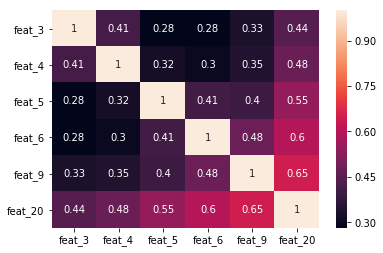

In [31]:
# Heatmap of strongest correlations
data_subset = data[["feat_3","feat_4", "feat_5", "feat_6", "feat_9","feat_20"]]
correlation_mat = data_subset.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [32]:
# now split labels from features
data, labels = preprocess_data(df, split_labels=True)
train_data, test_data, train_labels, test_labels = encode_and_split_data(data, labels, get="split_data")

ValueError: could not convert string to float: 'B'

In [101]:
# store accuracy measures in dict as we collect them
accs = dict()

In [102]:
# Logistic Regression classifier
accs["LogReg"] = train_eval_logreg([train_data, test_data], [train_labels, test_labels])
print(accs)

{'LogReg': 0.9910714285714286}


In [103]:
# RandomForest for potential feature reduction
clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced")
clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [104]:
# Sort features by importance
feature_import = [(a, b) for a, b in zip(list(data.columns), clf.feature_importances_)]
feature_import.sort(key=lambda a:a[1], reverse=True )
for f in feature_import:
    print(f)

('Used_app_before', 0.0944382853476318)
('Age_desc', 0.08109772190310854)
('Gender', 0.07791540726061819)
('A10_Score', 0.07531034445015809)
('A9_Score', 0.07347043307425867)
('Age', 0.05258670177957442)
('A7_Score', 0.04088389123782346)
('A8_Score', 0.034887127488020725)
('A6_Score', 0.03391026220764413)
('A3_Score', 0.028611282378984457)
('A5_Score', 0.024944071681582254)
('Jundice', 0.023550179414338415)
('Ethnicity', 0.023035329368251593)
('A1_Score', 0.02176701919382672)
('Relation', 0.020507546781339148)
('Family', 0.020117934366656418)
('A4_Score', 0.01992759825898421)
('A2_Score', 0.01732029051588326)
('Country_of_res', 0.017293034620127924)


In [105]:
# None of the features seem notably useful or not useful (age_desc is puzzling here), so just evaluate model as-is
accs["RandomForest"] = test_result(clf, test_data, test_labels)
print(accs)

{'LogReg': 0.9910714285714286, 'RandomForest': 0.9642857142857143}


In [106]:
# Try same 2 classifiers but with cross-validation instead of test/train
# Get all data featurized
feats = transform_data(data)

In [107]:
def predict_logreg(X, Y):
	scores = cross_val_score(LogisticRegression(solver='lbfgs'), X, Y, scoring='accuracy', cv=10)
	return scores.mean()

def predict_clf(X, Y):
	scores = cross_val_score(RandomForestClassifier(n_estimators=100), X, Y, scoring='accuracy', cv=10)
	return scores.mean()

In [111]:
accs["LogReg_CV"] = predict_logreg(feats.toarray(), labels)
accs["RandomForest_CV"] = predict_clf(feats.toarray(), labels)

In [112]:
for k, v in accs.items():
    print(k, round(v, 2))

LogReg 0.99
RandomForest 0.96
LogReg_CV 0.99
RandomForest_CV 0.96


In [113]:
# Try using mininum features based on correlations
subset_df = df[['A5_Score', 'A6_Score', 'A9_Score', 'ASD']].copy()
data, labels = preprocess_data(subset_df, split_labels=True)
train_data, test_data, train_labels, test_labels = encode_and_split_data(data, labels, get="split_data")

In [114]:
accs_sub = dict()

In [115]:
accs_sub["LogReg"] = train_eval_logreg([train_data, test_data], [train_labels, test_labels])

In [116]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced")
clf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [117]:
accs_sub["RandomForest"] = test_result(clf, test_data, test_labels)

In [118]:
# cross val with features minimized
feats = transform_data(data)
accs_sub["LogReg_CV"] = predict_logreg(feats.toarray(), labels)
accs_sub["RandomForest_CV"] = predict_clf(feats.toarray(), labels)

In [119]:
for k, v in accs_sub.items():
    print(k, round(v, 2))

LogReg 0.9
RandomForest 0.89
LogReg_CV 0.88
RandomForest_CV 0.88


Text(0.5, 1.0, 'Classifier Accuracy ASD Dataset')

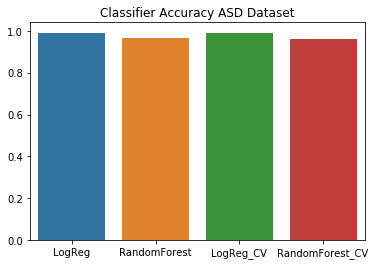

In [120]:
sns.barplot(x=list(accs.keys()), y=list(accs.values())).set_title("Classifier Accuracy ASD Dataset")

Text(0.5, 1.0, 'Reduced Feature Classifier Accuracy ASD Dataset')

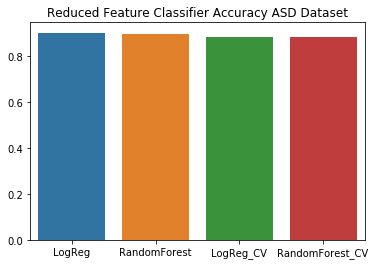

In [121]:
sns.barplot(x=list(accs_sub.keys()), y=list(accs_sub.values())).set_title("Reduced Feature Classifier Accuracy ASD Dataset")